# Machine Learning com PySpark


Este notebook tem como objetivo treinar e avaliar modelos de machine learning com base em dados de pacientes saudáveis e com doenças cardíacas. Ao final, novos dados serão fornecidos ao melhor modelo, para que ele faça a previsão se um paciente tem ou não alguma doença cardíaca.<br>

Os dados estão organizados da seguinte forma:
- <b>id:</b> ID único de cada paciente
- <b>idade:</b> Idade do paciente
- <b>sexo:</b> 0 (feminino) e 1 (masculino)
- <b>pressao_sanguinea:</b> Pressão sanguínea medida
- <b>colesterol:</b> Colesterol medido 
- <b>acucar_sangue:</b> Nível de açúcar no sangue - 0 (<= 120 mg/dl) e 1 (> 120 mg/dl)
- <b>ecg:</b> 0 (normal), 1 (alguma anomalia) e 2 (anomalia presente)
- <b>batimentos:</b> Batimento cardíaco medido
- <b>doenca:</b> Indica se o paciente tem doença cardíaca - 0 (não) e 1 (sim)

In [1]:
# PySpark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Python
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Customização dos gráficos
mpl.rc("axes", labelsize=12, titlesize=14)
mpl.rc("figure", figsize=(8, 5))

sns.set_style("darkgrid")
sns.set_palette("deep")

In [3]:
job_name = "ml-pacientes"

# Configuração da sessão Spark
conf = (SparkConf() \
    .setAppName(job_name) \
    .set("spark.sql.hive.metastore.jars.path","/opt/spark/jars") \
    .set("spark.hadoop.hive.metastore.uris", "thrift://localhost:9083") \
    .set("spark.sql.warehouse.dir", "hdfs://localhost:9000/user/hive/warehouse"))

In [4]:
# Cria a sessão Spark
spark = (SparkSession \
    .builder \
    .master("spark://192.168.15.2:7077") \
    .config(conf=conf) \
    .enableHiveSupport() \
    .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-10-13 18:11:34,584 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark

Agora que temos uma sessão Spark que pode se conectar ao metastore do Hive (rodando em background por meio do comando <code>hive --service metastore</code>), podemos consultar as bases de dados e tabelas que ali estão. Lembrando que o Hive funciona sobre o HDFS e é gerenciado pelo Yarn, então ambos os serviços devem estar rodando em background também.

In [6]:
# Consulta as bases de dados no Hive
spark.sql("show databases").show()

+---------+
|namespace|
+---------+
|  default|
|    spark|
+---------+



In [7]:
# Seleciona a base de dados spark
spark.sql("use spark")

DataFrame[]

In [8]:
# Verifica as tabelas da base de dados spark
spark.sql("show tables").show()

+---------+---------+-----------+
|namespace|tableName|isTemporary|
+---------+---------+-----------+
|    spark|pacientes|      false|
+---------+---------+-----------+



In [9]:
# Seleciona todos os dados e cria um DataFrame Spark
df = spark.sql("select * from pacientes")
df.show()

+----+-----+----+-----------------+----------+-------------+---+----------+------+
|  id|idade|sexo|pressao_sanguinea|colesterol|acucar_sangue|ecg|batimentos|doenca|
+----+-----+----+-----------------+----------+-------------+---+----------+------+
|1001|   63|   1|              145|       233|            1|  2|       150|     0|
|1002|   67|   1|              160|       286|            0|  2|       108|     1|
|1003|   67|   1|              120|       229|            0|  2|       129|     0|
|1004|   37|   1|              130|       250|            0|  0|       187|     0|
|1005|   41|   0|              130|       204|            0|  2|       172|     0|
|1006|   56|   1|              120|       236|            0|  0|       178|     0|
|1007|   62|   0|              140|       268|            0|  2|       160|     1|
|1008|   57|   0|              120|       354|            0|  0|       163|     0|
|1009|   63|   1|              130|       254|            0|  2|       147|     1|
|101

In [10]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- idade: integer (nullable = true)
 |-- sexo: integer (nullable = true)
 |-- pressao_sanguinea: integer (nullable = true)
 |-- colesterol: integer (nullable = true)
 |-- acucar_sangue: integer (nullable = true)
 |-- ecg: integer (nullable = true)
 |-- batimentos: integer (nullable = true)
 |-- doenca: integer (nullable = true)



O Spark identificou todos os tipos de dados corretamente.

In [11]:
df.count()

303

In [12]:
# Verificando duplicados
df.groupBy(df.columns).count().where("count > 1").show()

+---+-----+----+-----------------+----------+-------------+---+----------+------+-----+
| id|idade|sexo|pressao_sanguinea|colesterol|acucar_sangue|ecg|batimentos|doenca|count|
+---+-----+----+-----------------+----------+-------------+---+----------+------+-----+
+---+-----+----+-----------------+----------+-------------+---+----------+------+-----+



Como não há nenhuma ocorrência com count > 1, não há registros duplicados.

# Análise Exploratória

In [13]:
# Dropa a coluna id, pois não precisaremos dela
df = df.drop("id")

In [14]:
# Como o Spark retorna o resultado com muitas casas decimais, tornando a leitura difícil
# podemos usar alguns artifícios para melhorar a visualização
result = df.describe()

print(result.select(result["summary"],
    format_number(result["idade"].cast("float"), 2).alias("idade"),
    format_number(result["sexo"].cast("float"), 2).alias("sexo"),
    format_number(result["pressao_sanguinea"].cast("float"), 2).alias("pressao_sanguinea"),
    format_number(result["colesterol"].cast("float"), 2).alias("colesterol"),
    format_number(result["acucar_sangue"].cast("float"), 2).alias("acucar_sangue"),
    format_number(result["ecg"].cast("float"), 2).alias("ecg"),
    format_number(result["batimentos"].cast("float"), 2).alias("batimentos"),
    format_number(result["doenca"].cast("float"), 2).alias("doenca"),
    ).show())

+-------+------+------+-----------------+----------+-------------+------+----------+------+
|summary| idade|  sexo|pressao_sanguinea|colesterol|acucar_sangue|   ecg|batimentos|doenca|
+-------+------+------+-----------------+----------+-------------+------+----------+------+
|  count|303.00|303.00|           303.00|    303.00|       303.00|303.00|    303.00|303.00|
|   mean| 54.44|  0.68|           131.69|    246.69|         0.15|  0.99|    149.61|  0.28|
| stddev|  9.04|  0.47|            17.60|     51.78|         0.36|  0.99|     22.88|  0.45|
|    min| 29.00|  0.00|            94.00|    126.00|         0.00|  0.00|     71.00|  0.00|
|    max| 77.00|  1.00|           200.00|    564.00|         1.00|  2.00|    202.00|  1.00|
+-------+------+------+-----------------+----------+-------------+------+----------+------+

None


Pela tabela, aparentemente não há outliers, porém podemos avaliar isso melhor com alguns gráficos.

In [15]:
# Correlação entre as variáveis
for i in df.columns:
    print(f"Correlação entre {i} e doenca:", df.stat.corr("doenca", i))

Correlação entre idade e doenca: 0.20600334935171646
Correlação entre sexo e doenca: 0.17212056463885134
Correlação entre pressao_sanguinea e doenca: 0.1317836416253774
Correlação entre colesterol e doenca: 0.07584967584169872
Correlação entre acucar_sangue e doenca: 0.11454539741117296
Correlação entre ecg e doenca: 0.11750941989505952
Correlação entre batimentos e doenca: -0.39904045502780655
Correlação entre doenca e doenca: 1.0


Basicamente, todas as variáveis têm uma correlação fraca com o target. Apenas a correlação com a variável <b>batimentos</b> é mais relevante, mas negativamente.<br>

Podemos utilizar o pandas para visualizar mais facilmente a correlação entre todas as variáveis de uma vez. Assim será mais fácil identificar se há colinearidade ou não. Além disso, com o DataFrame do pandas podemos utilizar as bibliotecas de dataviz mais facilmente.

In [16]:
# Converte o df do Spark para o df do pandas
df_pd = df.toPandas()
df_pd.head()

,idade,sexo,pressao_sanguinea,colesterol,acucar_sangue,ecg,batimentos,doenca
0,63,1,145,233,1,2,150,0
1,67,1,160,286,0,2,108,1
2,67,1,120,229,0,2,129,0
3,37,1,130,250,0,0,187,0
4,41,0,130,204,0,2,172,0


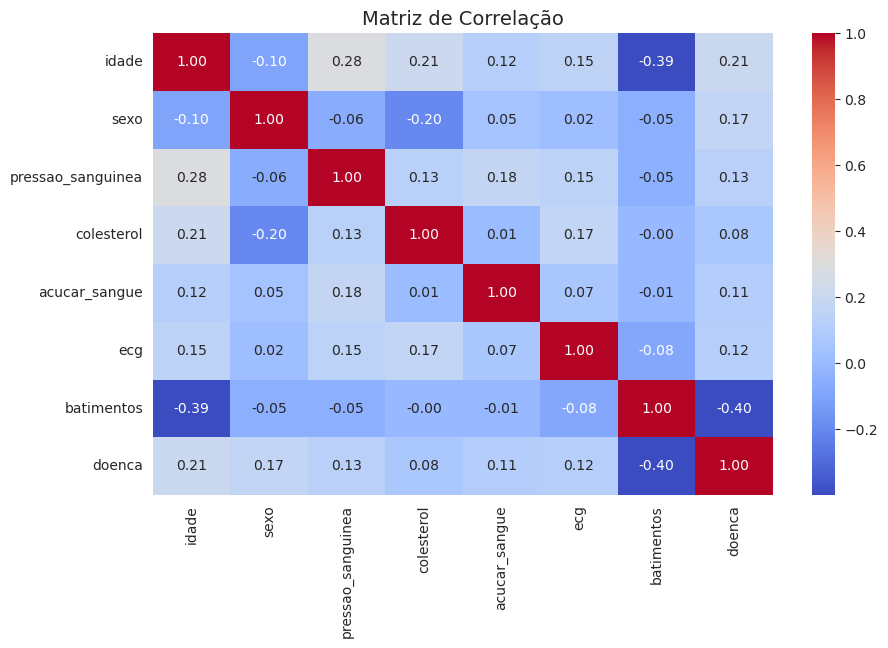

In [17]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_pd.corr(), cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Matriz de Correlação")

plt.show()

Ok! Sem problemas com colinearidade.<br>

Vamos analisar graficamente a distribuição das variáveis em relação ao target.

In [18]:
# Distribuição do target
df_pd["doenca"].value_counts()

0    219
1     84
Name: doenca, dtype: int64

A variável alvo está levemente desbalanceada, mas não será necessário balancear o dataset.

## Variáveis numéricas

In [19]:
# Separando as colunas em numéricas e categóricas
num_cols = ["idade", "pressao_sanguinea", "colesterol", "batimentos"]
cat_cols = ["sexo", "acucar_sangue", "ecg"]

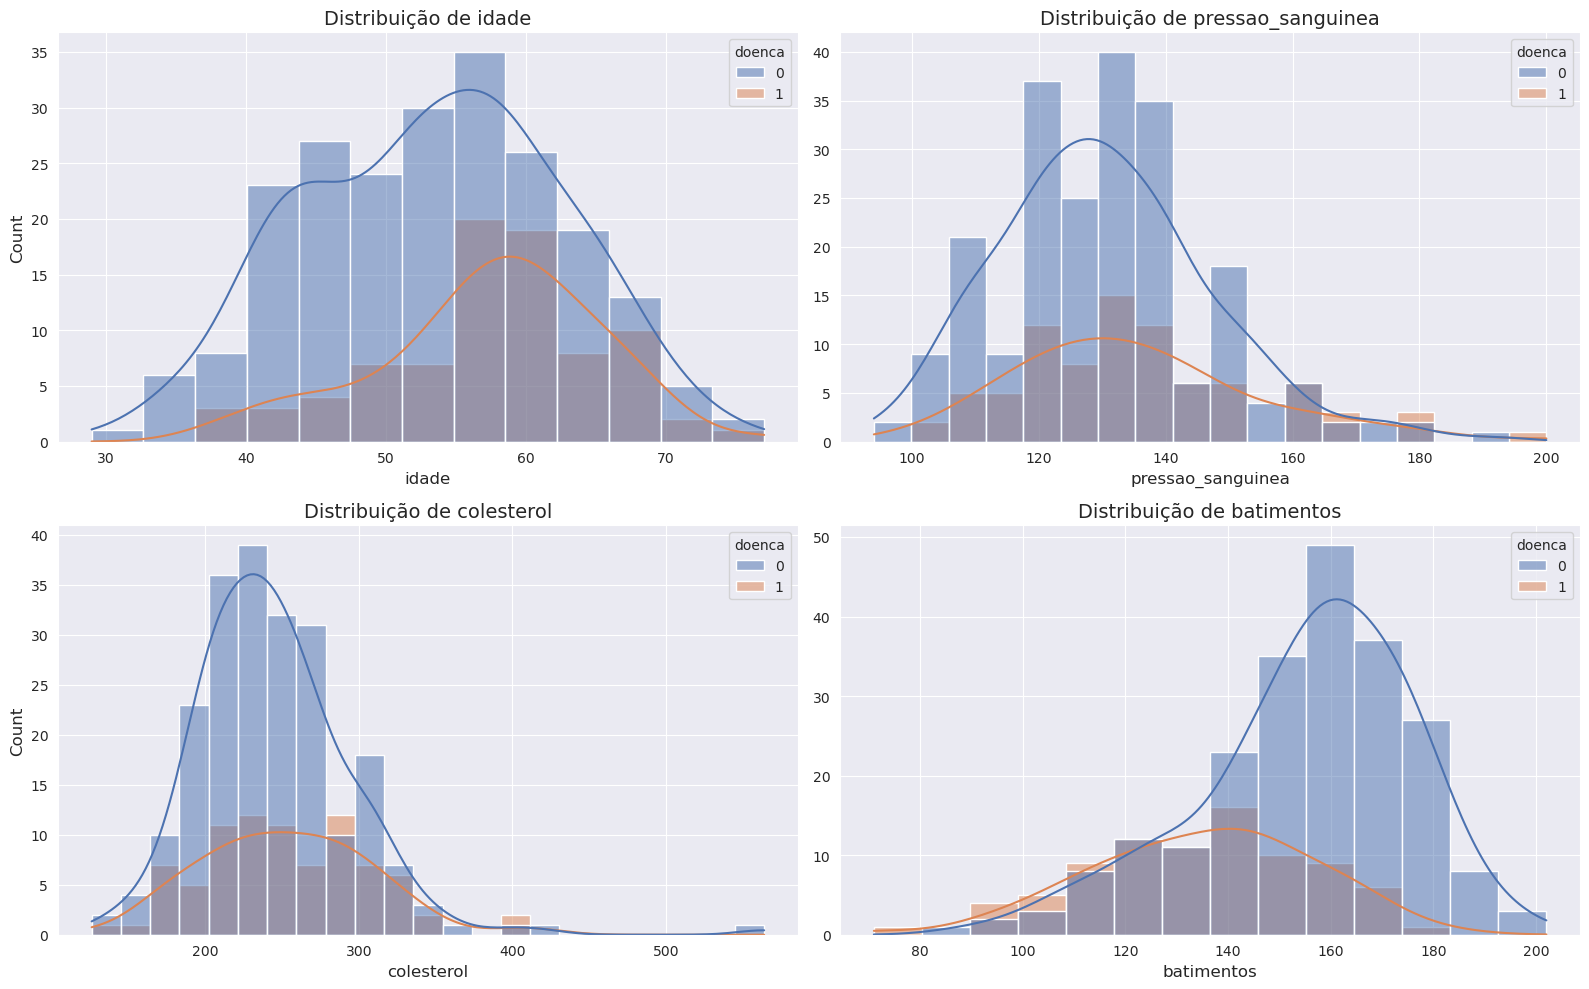

In [20]:
fig = plt.figure(figsize=(16, 10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i + 1)
    g = sns.histplot(data=df_pd, x=col, hue="doenca", kde=True)
    g.set_title(f"Distribuição de {col}")
    
    if (i + 1) % 2 == 0:
        g.set_ylabel("")
    

fig.tight_layout()
plt.show()

A distribuição das variáveis <b>idade</b> e <b>pressao_sanguinea</b> estão bem próximas de uma normal, enquanto <b>colesterol</b> e <b>batimentos</b> estão levemente assimétricas, para a direita e esquerda, respectivamente.<br>

Em relação à positividade da doença cardíaca, é difícil verificar qualquer padrão, mas, aparentemente, pacientes mais velhos tiveram uma chance maior de desenvolver a doença. Além disso, pacientes com batimentos em torno de 140 tiveram problemas cardíacos com maior frequência.<br>

Para averiguar melhor a questão de outliers, podemos visualizar os dados com box plots.

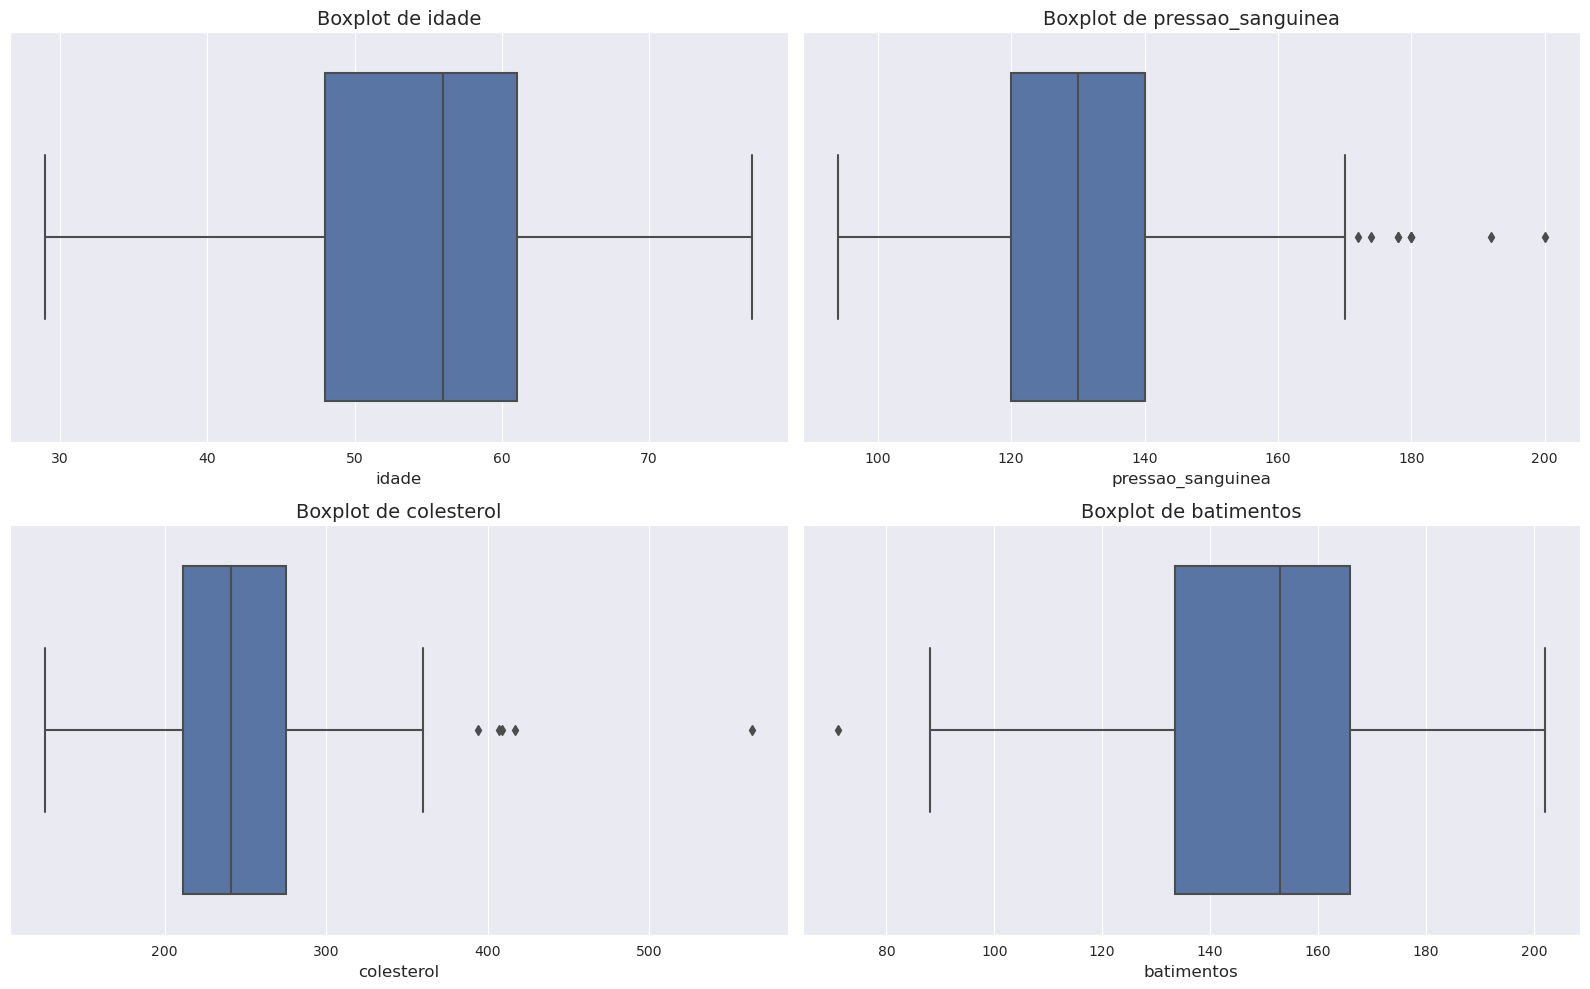

In [21]:
fig = plt.figure(figsize=(16, 10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i + 1)
    g = sns.boxplot(data=df_pd, x=col)
    g.set_title(f"Boxplot de {col}")
    
    if (i + 1) % 2 == 0:
        g.set_ylabel("")
    

fig.tight_layout()
plt.show()

O caso mais crítico é o do colesterol acima de 500. Podemos remover este registro.

In [22]:
df_pd = df_pd[df_pd["colesterol"] < 500]

## Variáveis categóricas

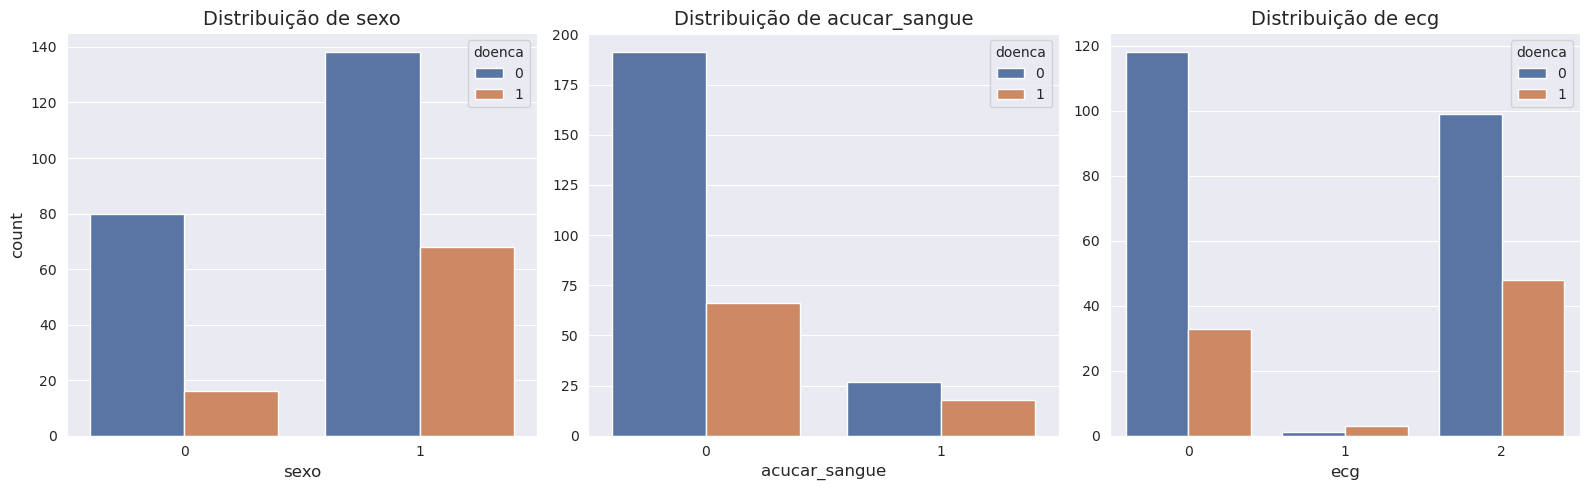

In [23]:
fig = plt.figure(figsize=(16, 5))

for i, col in enumerate(cat_cols):
    plt.subplot(1, 3, i + 1)
    g = sns.countplot(data=df_pd, x=col, hue="doenca")
    g.set_title(f"Distribuição de {col}")
    
    if i > 0:
        g.set_ylabel("")
    

fig.tight_layout()
plt.show()

Novamente, é difícil de verificar qualquer padrão nos dados. No entanto, algo que podemos ver é que pacientes com alto nível de açúcar no sangue tiveram uma distribuição praticamente igual de ter uma doença ou não.

# Pré-processamento dos Dados

In [24]:
# Voltamos ao DataFrame Spark
df = spark.createDataFrame(df_pd)

# Precisamos renomear a variável alvo para "label"
df = df.withColumnRenamed("doenca", "label")
df.show(5)

+-----+----+-----------------+----------+-------------+---+----------+-----+
|idade|sexo|pressao_sanguinea|colesterol|acucar_sangue|ecg|batimentos|label|
+-----+----+-----------------+----------+-------------+---+----------+-----+
|   63|   1|              145|       233|            1|  2|       150|    0|
|   67|   1|              160|       286|            0|  2|       108|    1|
|   67|   1|              120|       229|            0|  2|       129|    0|
|   37|   1|              130|       250|            0|  0|       187|    0|
|   41|   0|              130|       204|            0|  2|       172|    0|
+-----+----+-----------------+----------+-------------+---+----------+-----+
only showing top 5 rows



In [25]:
# Preparação do VectorAssembler
vector = VectorAssembler(inputCols=df.drop("label").columns, outputCol="features")

# Aplica o vetorizador
df_vectorized = vector.transform(df).select("features", "label")
df_vectorized.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[63.0,1.0,145.0,2...|    0|
|[67.0,1.0,160.0,2...|    1|
|[67.0,1.0,120.0,2...|    0|
|[37.0,1.0,130.0,2...|    0|
|[41.0,0.0,130.0,2...|    0|
+--------------------+-----+
only showing top 5 rows



In [26]:
# Divisão dos dados em treino e teste
(df_train, df_test) = df_vectorized.randomSplit([0.7, 0.3])

print("Dados de treino:", df_train.count())
print("Dados de teste:", df_test.count())

Dados de treino: 208
Dados de teste: 94


In [27]:
# Padronização dos dados
# Cria o objeto
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
# scaler = MinMaxScaler(min=0.0, max=1.0, inputCol="features", outputCol="features_scaled")

# Treina o scaler com dados de treino
scaler_fitted = scaler.fit(df_train)

# Aplica o padronizador nos dados
df_train = scaler_fitted.transform(df_train)
df_test = scaler_fitted.transform(df_test)

In [28]:
df_train.drop("features").show(5, truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------+
|label|features_scaled                                                                                                    |
+-----+-------------------------------------------------------------------------------------------------------------------+
|0    |[3.2428634966503873,2.213082990137882,7.459469181574796,4.2957139402710744,0.0,2.017030392313183,8.584801353776319]|
|0    |[3.9138007718194334,2.213082990137882,6.885663859915197,4.169369412616043,0.0,0.0,5.524872158370899]               |
|0    |[4.1374465302091155,2.213082990137882,7.459469181574796,5.264355318959651,0.0,0.0,7.947316104733524]               |
|1    |[4.361092288598797,2.213082990137882,6.770902795583277,4.611575259408654,0.0,0.0,5.9498623243994295]               |
|0    |[4.472915167793638,2.213082990137882,8.033274503234397,4.190426833891881,0.0,0.0,7.564824955307846]                |
+-----+-

In [29]:
df_test.drop("features").show(5, truncate=False)

+-----+-------------------------------------------------------------------------------------------------------------------+
|label|features_scaled                                                                                                    |
+-----+-------------------------------------------------------------------------------------------------------------------+
|0    |[3.8019778926245924,2.213082990137882,6.770902795583277,3.8324506722026257,0.0,2.017030392313183,7.394828888896433]|
|0    |[3.9138007718194334,0.0,7.918513438902476,3.8535080934784642,0.0,0.0,7.734821021719259]                            |
|0    |[4.361092288598797,2.213082990137882,8.033274503234397,6.759432229544191,0.0,2.017030392313183,7.734821021719259]  |
|1    |[4.472915167793638,2.213082990137882,6.311858538255597,3.5165893530650463,0.0,2.017030392313183,4.844887892725249] |
|1    |[4.920206684573002,2.213082990137882,6.426619602587517,6.106652169993194,0.0,2.017030392313183,6.502349540236519]  |
+-----+-

# Treinamento e Avaliação dos algoritmos

In [30]:
# Colunas a serem usadas
clf_cols = {"labelCol": "label", "featuresCol": "features_scaled"}

# Lista de algoritmos
classifiers = [LogisticRegression(**clf_cols),
               DecisionTreeClassifier(**clf_cols),
               RandomForestClassifier(**clf_cols),
               NaiveBayes(**clf_cols),
               GBTClassifier(**clf_cols)]

In [31]:
# Dicionário de hiperparâmetros
paramDict = {
    "DecisionTreeClassifier": (ParamGridBuilder() \
                                   .addGrid(classifiers[1].maxBins, [10, 20, 40]) \
                                   .addGrid(classifiers[1].impurity, ["gini", "entropy"]) \
                                   .build()),
    "RandomForestClassifier": (ParamGridBuilder() \
                                   .addGrid(classifiers[2].maxBins, [10, 20, 40]) \
                                   .addGrid(classifiers[2].impurity, ["gini", "entropy"]) \
                                   .addGrid(classifiers[2].numTrees, [10, 20, 40]) \
                                   .build()),
    "NaiveBayes": (ParamGridBuilder() \
                                   .addGrid(classifiers[3].smoothing, [0.25, 0.5, 1]) \
                                   .build()),
    "GBTClassifier": (ParamGridBuilder() \
                                   .addGrid(classifiers[4].maxBins, [10, 20, 40]) \
                                   .addGrid(classifiers[4].maxIter, [10, 20, 40]) \
                                   .build())
}

In [32]:
# Dicionário para guardar os modelos treinados
modelsDict = {type(clf).__name__:i for i, clf in enumerate(classifiers)}
modelsDict

{'LogisticRegression': 0,
 'DecisionTreeClassifier': 1,
 'RandomForestClassifier': 2,
 'NaiveBayes': 3,
 'GBTClassifier': 4}

In [33]:
def func_ml(clf):
    
    """Esta função vai receber o algoritmo para treiná-lo e avaliá-lo, já com a tunagem de hiperparâmetros"""
    
    # Pega o nome do algoritmo
    clf_name = type(clf).__name__
    
    # Métricas para avaliar os modelos
    # Cria os objetos avaliadores
    accuracy = MulticlassClassificationEvaluator(predictionCol="prediction",
                                                 labelCol="label",
                                                 metricName="accuracy")
    f1 = MulticlassClassificationEvaluator(predictionCol="prediction",
                                                 labelCol="label",
                                                 metricName="f1")
    
    # O primeiro algoritmo, LogisticRegression(), será treinado sem validação cruzada (atuará como Benchmark)
    if clf_name == "LogisticRegression":
    
        # Treina e faz as predições
        model = clf.fit(df_train)
        predictions = model.transform(df_test)

        # Métricas do modelo
        print("\033[1m" + f"{clf_name} sem validação cruzada" + "\033[0m")
        print("")

        result_acc = accuracy.evaluate(predictions)
        result_f1 = f1.evaluate(predictions)

        # Imprime as métricas
        print(f"Accuracy em teste: {result_acc}")
        print(f"F1 Score em teste: {result_f1}")
        print("")

        # DataFrame com os resultados
        # Lista para o schema
        schema = ["Model", "Accuracy", "F1 Score"]

        # Cria o DataFrame
        df_result = spark.createDataFrame(zip([clf_name], [result_acc], [result_f1]), schema=schema)

        return df_result, model
        
    # Mesmo processo, porém agora com validação cruzada
    for key, params in paramDict.items():
        if clf_name == key:
            paramGrid = params

            # Prepara o CrossValidator
            cv = CrossValidator(estimator=clf,
                                estimatorParamMaps=paramGrid,
                                evaluator=f1,
                                numFolds=3,
                                seed=12)

            # Treina o modelo usando validação cruzada
            model = cv.fit(df_train)

            # Extrai o melhor modelo
            best_model = model.bestModel

            # Faz as predições com o melhor modelo
            predictions = model.transform(df_test)

                # Métricas do modelo
            print("\033[1m" + f"{clf_name} com validação cruzada" + "\033[0m")
            print("")

            result_acc = accuracy.evaluate(predictions)
            result_f1 = f1.evaluate(predictions)

            # Imprime as métricas
            print(f"Accuracy em teste: {result_acc}")
            print(f"F1 Score em teste: {result_f1}")
            print("")

            # DataFrame com os resultados
            # Lista para o schema
            schema = ["Model", "Accuracy", "F1 Score"]

            # Cria o DataFrame
            df_result = spark.createDataFrame(zip([clf_name], [result_acc], [result_f1]), schema=schema)

            return df_result, best_model

In [34]:
# DataFrame para armazenar os resultados finais
# Lista com o schema e valores
schema = ["Model", "Accuracy", "F1 Score"]
values = [("N/A", "N/A", "N/A")]

# Cria o DataFrame
df_result_final = spark.createDataFrame(values, schema=schema)
df_result_final.show()

+-----+--------+--------+
|Model|Accuracy|F1 Score|
+-----+--------+--------+
|  N/A|     N/A|     N/A|
+-----+--------+--------+



In [35]:
for classifier in classifiers:
    
    # Resultado de cada classificador e melhor modelo
    df_result, modelsDict[type(classifier).__name__] = func_ml(classifier)
    
    # Grava os resultados no DataFrame
    df_result_final = df_result_final.union(df_result)

LogisticRegression sem validação cruzada



Accuracy em teste: 0.7127659574468085
F1 Score em teste: 0.6991728819516911

DecisionTreeClassifier com validação cruzada

Accuracy em teste: 0.7021276595744681
F1 Score em teste: 0.7102836879432622

RandomForestClassifier com validação cruzada

Accuracy em teste: 0.7340425531914894
F1 Score em teste: 0.699153511782201

NaiveBayes com validação cruzada

Accuracy em teste: 0.7340425531914894
F1 Score em teste: 0.6892882591836468



GBTClassifier com validação cruzada

Accuracy em teste: 0.6914893617021277
F1 Score em teste: 0.6980534178361251



In [36]:
df_result_final.where("Model <> 'N/A'").show(truncate=False)

+----------------------+------------------+------------------+
|Model                 |Accuracy          |F1 Score          |
+----------------------+------------------+------------------+
|LogisticRegression    |0.7127659574468085|0.6991728819516911|
|DecisionTreeClassifier|0.7021276595744681|0.7102836879432622|
|RandomForestClassifier|0.7340425531914894|0.699153511782201 |
|NaiveBayes            |0.7340425531914894|0.6892882591836468|
|GBTClassifier         |0.6914893617021277|0.6980534178361251|
+----------------------+------------------+------------------+



In [37]:
modelsDict

{'LogisticRegression': LogisticRegressionModel: uid=LogisticRegression_2281d031e276, numClasses=2, numFeatures=7,
 'DecisionTreeClassifier': DecisionTreeClassificationModel: uid=DecisionTreeClassifier_05890dc31c6f, depth=5, numNodes=35, numClasses=2, numFeatures=7,
 'RandomForestClassifier': RandomForestClassificationModel: uid=RandomForestClassifier_63ca5e1e6999, numTrees=10, numClasses=2, numFeatures=7,
 'NaiveBayes': NaiveBayesModel: uid=NaiveBayes_14eb17215ef5, modelType=multinomial, numClasses=2, numFeatures=7,
 'GBTClassifier': GBTClassificationModel: uid = GBTClassifier_0e21710c37b5, numTrees=20, numClasses=2, numFeatures=7}

Após treino, tunagem de hiperparâmetros e avaliação com dados de teste, podemos ver que o modelo RandomForest se saiu um pouco melhor que o restante. O resultado não é excelente, mas houve uma melhora em relação ao modelo benchmark (LogisticRegression).

# Teste com novos dados


Para finalizar este projeto, iremos avaliar o modelo RandomForest com novos dados, selecionados aleatoriamente, com o intuito de avaliar a sua generalização.

In [38]:
df.columns[:-1]

['idade',
 'sexo',
 'pressao_sanguinea',
 'colesterol',
 'acucar_sangue',
 'ecg',
 'batimentos']

In [39]:
# Novos dados
new_data = [(45, 0, 136, 288, 1, 2, 120)]
schema = df.columns[:-1]

# Cria o DataFrame
new_df = spark.createDataFrame(new_data, schema)
new_df.show()

+-----+----+-----------------+----------+-------------+---+----------+
|idade|sexo|pressao_sanguinea|colesterol|acucar_sangue|ecg|batimentos|
+-----+----+-----------------+----------+-------------+---+----------+
|   45|   0|              136|       288|            1|  2|       120|
+-----+----+-----------------+----------+-------------+---+----------+



In [40]:
# Aplicamos as mesmas transformações feitas anteriormente
# Cria o VectorAssembler
assembler = VectorAssembler(inputCols=new_df.columns, outputCol="features")

# Aplica o assembler
new_df = assembler.transform(new_df).select("features")
new_df.show(truncate=False)

+------------------------------------+
|features                            |
+------------------------------------+
|[45.0,0.0,136.0,288.0,1.0,2.0,120.0]|
+------------------------------------+



In [41]:
# Padroniza os dados
new_df_scaled = scaler_fitted.transform(new_df)
new_df_scaled.select("features_scaled").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                   |
+------------------------------------------------------------------------------------------------------------------+
|[5.032029563767843,0.0,7.803752374570556,6.064537327441517,2.6666116151763135,2.017030392313183,5.099881992342368]|
+------------------------------------------------------------------------------------------------------------------+



In [42]:
# Cria o objeto do modelo RandomForest
randomForest = modelsDict["RandomForestClassifier"]

# Faz as predições
predictions = randomForest.transform(new_df_scaled)

# Resultado
predictions.select("features", "prediction").show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[45.0,0.0,136.0,2...|       1.0|
+--------------------+----------+



Conforme podemos ver, o modelo previu que a paciente de 45 anos e com anomalia presente em seu exame deve ter alguma doença cardíaca. Tal resultado se mostra bastante plausível de acordo com a literatura médica.